# 📓 Notebook 1 – Exploratory Data Analysis (EDA) of Pose Outputs

## 1. Introduction & objectives

In this notebook, we will explore pose estimation outputs generated with SuperAnimal ModelZoo on 10-minute top-view mouse videos.

**Learning goals:**
- Understand the structure of .h5 output files
- Explore metadata and summary statistics
- Visualize likelihoods, trajectories, and skeletons
- Detect and correct errors (missing points, jumps)
- Compare outputs from clear vs challenging videos
- Prepare cleaned data for further analysis

--- 
**Instructions**

This notebook mixes pre-filled code cells (nothing to change) and coding exercises that you will complete.

👉 Here’s how to work through it:
1. Read carefully each section before running the cells.
2.	When a cell requires you to code, you’ll see a TODO comment.
3.	The TODO will tell you how many lines to write.
4.	Write your code only between the markers:
    
```python
# >>>>>>>>>>>>>>>>>>>
# your code goes here
# <<<<<<<<<<<<<<<<<<<
```

✋ Do not edit anything outside these markers.

⚡ After finishing the course, feel free to experiment and modify the notebook as you like!

✨ Example

What you will see in the notebook:

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
# YOUR CODE: duration = 
# YOUR CODE: print(...)
# <<<<<<<<<<<<<<<<<<< 
```

What you are expected to write: 

```python
# >>>>>>>>>>>>>>>>>>>
# TODO (2 lines): compute the duration of the video and print it 
# variables: frame_count, fps
duration = frame_count / fps
print(f"Duration (s):", duration)
# <<<<<<<<<<<<<<<<<<< 
```
---
  

<img src="https://raw.githubusercontent.com/LizbethMG-Teaching/pose2behav-book/main/assets/notebook-image1.png" width="50%">

**Narrative**

Imagine you are a junior researcher in a neuroscience lab. Your colleague just handed you pose estimation outputs generated with SuperAnimal ModelZoo from 5-minute videos of mice exploring an arena. Before you can ask scientific questions about locomotion, posture, or social behavior, you need to verify the quality of these model predictions. What are the keypoints tracked? Are all the keypoints tracked reliably? Do some body parts drop out in certain conditions? 

In this notebook, you will take the role of a data detective: opening the .h5 pose files, exploring the structure, visualizing likelihoods and trajectories, spotting errors, and applying simple corrections. By the end, you will produce a short “quality report” that prepares you for deeper behavioral analysis in the next notebooks.

--- 


## 2. Data Loading & Format Inspection

👉 Goal: learn to open .h5 files and understand their structure.
- Load one file into a pandas DataFrame
- Inspect columns: scorer, bodypart, x, y, likelihood
- Count frames and list bodyparts

### 2.1 Download data (prefilled)

**📋 Instructions:**
1. Run the code cell below to download a dataset file from Google Drive (with gdown), save it locally (path depends on Colab vs local), and verify the download.

In [132]:
# PREFILLED, NO NEED TO CHANGE, JUST RUN THIS CELL
# Install and import the required libraries:
!pip -q install gdown tables

import os
from pathlib import Path
import gdown, pandas as pd, numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby

# --------------------------------------------------------------

# Detect if running in Google Colab
if "COLAB_RELEASE_TAG" in os.environ or "COLAB_GPU" in os.environ:
    DEST = Path("/content/dlc_output.h5")
else:
    DEST = Path("dlc_output.h5")  # save in current folder locally
print("Saving to:", DEST)

# Select here the experiment you want to download, comment the others:
# Opt 1: Single mouse - arena with bedding
FILE_ID = "1JEpAtkANcXLb9Tsg0GrdNxjQTlx3edlk"
# Opt 2: Single mouse - arena without clear floor
# FILE_ID = 
# Opt 3: Single mouse - beatbox
#FILE_ID = "11zcVPSS4D-JLQQ11hkMbPwmqs-cd6Am2"

URL = f"https://drive.google.com/uc?id={FILE_ID}"

print("Downloading from Drive...")
_ = gdown.download(URL, str(DEST), quiet=False)

# Basic checks
assert DEST.exists() and DEST.stat().st_size > 0, "❌ Download failed or empty file."
print(f"✅ Downloaded to {DEST} ({DEST.stat().st_size/1_000_000:.2f} MB)")

Saving to: dlc_output.h5


Downloading...
From: https://drive.google.com/uc?id=1JEpAtkANcXLb9Tsg0GrdNxjQTlx3edlk
To: /Users/lix/Library/CloudStorage/OneDrive-Personnel/3-work/teaching/2025_BehavioralAnalysis/pose2behav-book/notebooks/dlc_output.h5
100%|██████████| 58.5M/58.5M [00:04<00:00, 12.1MB/s]

✅ Downloaded to dlc_output.h5 (58.47 MB)


---

### 2.2 Load the H5 into a DataFrame, explore the content.

**📋 Instructions:**

1. Load the HDF5 pose estimation output into a Pandas DataFrame using the provided `read_pose_h5()` function.
2. 🧩 Complete the line marked with `# TODO` to run a basic sanity check: 
- Verify that the DataFrame `df` is **not empty** (has at least one row).  


In [133]:
# Load the HDF5 pose output into a pandas DataFrame.

def read_pose_h5(path: Path) -> pd.DataFrame:
    for key in ("df_with_missing", "df", "tracks", "pose"):
        try:
            return pd.read_hdf(path, key=key)
        except Exception:
            pass
        
    return pd.read_hdf(path)

df = read_pose_h5(DEST)

# Basic sanity check

# >>>>>>>>>>>>>>>>>>>
# TODO: Check that the DataFrame "df" has at least 1 row.
# Clue: ( assert <logical statement>, “message to return if assertion fails” )
#   If the file was loaded but empty (no rows), this condition is False.
#   If condition is True, nothing happens, code continues.
# YOUR CODE HERE: assert ...
assert df.shape[0] > 0, "Empty DataFrame after loading. Check file."
# <<<<<<<<<<<<<<<<<<<

print("✅ H5 loaded.")

# Show dataframe info
print("📊 Data shape:", df.shape)
# Display the first 5 rows as a nice HTML table
display(df)

✅ H5 loaded.
📊 Data shape: (9000, 810)


scorer      superanimal_topviewmouse_snapshot-fasterrcnn_resnet50_fpn_v2-004_snapshot-hrnet_w32-004  \
individuals                                                                                 animal0   
bodyparts                                                                                      nose   
coords                                                                                            x   
0                                                   783.023438                                        
1                                                   777.289062                                        
2                                                   776.617188                                        
3                                                   776.054688                                        
4                                                   775.367188                                        
...                                                        ...                                        
8995                                                 -1.000000                                        
8996                                                558.781250                                        
8997                                                550.406250                                        
8998                                                543.226562                                        
8999                                                 -1.000000                                        

scorer                                                                 \
individuals                                                             
bodyparts                             left_ear                          
coords                y likelihood           x           y likelihood   
0            262.625000        1.0  797.960938  273.875000   1.000000   
1            261.625000        1.0  795.960938  276.625000   1.000000   
2            265.718750        1.0  791.429688  276.781250   1.000000   
3            268.445312        1.0  790.664062  277.210938   0.981241   
4            271.132812        1.0  793.648438  277.226562   1.000000   
...                 ...        ...         ...         ...        ...   
8995          -1.000000       -1.0   -1.000000   -1.000000  -1.000000   
8996         269.656250        1.0  578.656250  276.281250   1.000000   
8997         271.843750        1.0  568.843750  275.531250   1.000000   
8998         272.960938        1.0  561.429688  276.601562   1.000000   
8999          -1.000000       -1.0   -1.000000   -1.000000  -1.000000   

scorer                                                       ...  \
individuals                                                  ...   
bodyparts     right_ear                        left_ear_tip  ...   
coords                x           y likelihood            x  ...   
0            812.898438  255.125000    1.00000   801.695312  ...   
1            807.164062  257.875000    1.00000   795.960938  ...   
2            806.242188  258.343750    1.00000   795.132812  ...   
3            802.351562  259.679688    1.00000   796.507812  ...   
4            802.789062  258.945312    1.00000   796.695312  ...   
...                 ...         ...        ...          ...  ...   
8995          -1.000000   -1.000000   -1.00000    -1.000000  ...   
8996         575.343750  249.781250    0.94786   578.656250  ...   
8997         568.843750  249.718750    1.00000   572.531250  ...   
8998         561.429688  247.476562    1.00000   565.070312  ...   
8999          -1.000000   -1.000000   -1.00000    -1.000000  ...   

scorer                                                                        \
individuals       animal9                                                      
bodyparts   right_midside right_hip                 tail_end                   
coords         likelihood         x    y likelihood        x    y likelihood   
0                

--- 
### 2.3 - **List parts**

Let’s list the columns we just saw to answer:  
- How many individuals are in the file?  
- How many body parts are included, and which ones?

**📋 Instructions:**
1. Run the code cell below and verify the output.

In [134]:
# 👉🏼 PREFILLED, NO NEED TO CHANGE, JUST RUN THIS CELL
# Extract column multiindex levels
animals = df.columns.get_level_values("individuals").unique()
bodyparts = df.columns.get_level_values("bodyparts").unique()

print("Number of animals:", len(animals))
print("Animals:", animals.tolist())
print("Number of bodyparts:", len(bodyparts))
print("Bodyparts:", bodyparts.tolist())

Number of animals: 10
Animals: ['animal0', 'animal1', 'animal2', 'animal3', 'animal4', 'animal5', 'animal6', 'animal7', 'animal8', 'animal9']
Number of bodyparts: 27
Bodyparts: ['nose', 'left_ear', 'right_ear', 'left_ear_tip', 'right_ear_tip', 'left_eye', 'right_eye', 'neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3', 'tail_base', 'tail1', 'tail2', 'tail3', 'tail4', 'tail5', 'left_shoulder', 'left_midside', 'left_hip', 'right_shoulder', 'right_midside', 'right_hip', 'tail_end', 'head_midpoint']


**Why do we see 10 animals if the video had only 1 mouse?**

When you use a pretrained model from the **ModelZoo** (like SuperAnimal), the model was trained to detect **multiple individuals** (e.g. 10 animals in one arena).
That’s why your `.h5` file may show entries like: individual_0, individual_1, …, individual_9

Even if your analyzed video contains **only one animal**, the model still outputs placeholders for all possible individuals it was trained to detect.

This doesn’t mean it *found* 10 animals, just that the configuration and model expect up to 10.

In a **single-mouse experiment**:  
- Only one slot (usually `animal0`) contains meaningful coordinates.  
- Whenever no mouse is detected for a given slot, its entries are filled with **sentinel values** (-1 for coordinates and likelihood).

⚙️ If you train your own model in the future: 

when you create your own DeepLabCut project, you can control this in your `config.yaml` file:
DeepLabCut uses the list of `individuals` defined there to decide how many animals to include in the output.  
You can modify this section to include multiple individuals, for example:
```yaml
individuals:
  - animal_0
  - animal_1
  - animal_2
```

Or for a single animal: 

```yaml
individuals:
  - animal_0
```
This change tells DLC to create separate tracks for each animal detected by the network.

Using ModelZoo: 
👉 **in practice:** You only need to keep the data for the detected individual(s) with the **highest likelihoods** and ignore the unused slots.  

---

### 2.4 - Evaluate tracking quality per animal
**How do we find the real animal?**
In a single-animal video this will usually be `animal0`.  
However, **misassignments can occur** — for instance, the detected mouse may occasionally be labeled as another slot (`animal1`, `animal2`, etc.).  
In single-animal settings this is easy to quantify by checking which slot contains valid tracking data,  
but in **multi-animal experiments** such swaps require more careful verification.

**📋 Instructions:**

1. Run the code cell below, it defines a helper function (not running yet) to compute the following metrics for each animal:
- **mean_likelihood:** averages the detection likelihood (≈ 1 for real, = NaN if no animal detected)
- **frac_conf:** the fraction of points with likelihood ≥ 0.5. Real animals have a high fraction; empty slots have ~0.
- **mean_xy_var:** It’s the average variance (how much a value changes overtime) of the x and y coordinates for an animal across frames, computed only where likelihoods are valid (≥0) or in simpler terms: how much this animal’s detected bodyparts move in the video

1. Inspect the output table and identify which animal shows high confidence values.
   
A partially empty animal (or a fake animal ) may have just a few noisy detections → small variance, but with nearly zero likelihood confidence.



In [135]:
# PREFILLED, NO NEED TO CHANGE, JUST RUN THIS CELL
# Helper to summarize per-animal signal quality & motion

def animal_activity_summary(df: pd.DataFrame, conf_thresh: float = 0.5) -> pd.DataFrame:
    """
    Returns a small per-animal table with:
      - mean_likelihood : mean over all bodyparts/frames (often -1 when unused)
      - frac_conf       : fraction of points with likelihood >= conf_thresh (ignores <0)
      - mean_xy_var     : average variance of x/y where detections exist
    Sorted so the most likely real animal is on top.
    """
    if not isinstance(df.columns, pd.MultiIndex):
        raise ValueError("Expected MultiIndex columns (scorer/individuals/bodyparts/coords).")
    expected = ['scorer', 'individuals', 'bodyparts', 'coords']
    if list(df.columns.names) != expected:
        raise ValueError(f"Unexpected column levels: {df.columns.names} (expected {expected})")

    idx = pd.IndexSlice
    animals = df.columns.get_level_values("individuals").unique()

    rows = []
    for a in animals:
        A = df.xs(a, axis=1, level="individuals")

        # Likelihoods table: (frames, bodyparts)
        L = A.xs("likelihood", axis=1, level="coords")
        mean_L = float(L.where(L >= 0).mean().mean())

        # Valid (>=0) then fraction above threshold
        L_valid = L.where(L >= 0)
        frac_conf = float((L_valid >= conf_thresh).mean().mean())

        # Build masked XY (only where L is valid) to get motion variance
        XY = A.loc[:, idx[:, :, ["x", "y"]]]  # (frames, bodyparts, coords[x,y])

        det_mask = L_valid.notna()  # (frames, bodyparts)
        # duplicate mask for x and y, then reorder levels to match XY
        mask_xy = pd.concat([det_mask, det_mask], axis=1, keys=["x", "y"])
        mask_xy = mask_xy.swaplevel(0, 2, axis=1).swaplevel(0, 1, axis=1).sort_index(axis=1)
        mask_xy = mask_xy.reindex(columns=XY.columns)

        mov_var = float(XY.where(mask_xy).var(ddof=0).mean())

        rows.append((a, mean_L, frac_conf, mov_var))

    out = (pd.DataFrame(rows, columns=["animal", "mean_likelihood", "frac_conf", "mean_xy_var"])
             .set_index("animal")
             .sort_values(["frac_conf", "mean_xy_var", "mean_likelihood"], ascending=False))
    return out


📝 **Instructions**

You will now detect the most likely **real animal** using the helper function defined above.

1. 🧩 Complete the line marked with `# TODO` to use the helper function `animal_activity_summary()` and compute a **per-animal summary**.  
2. Start with a confidence threshold `conf_thresh = 0.5`.  
3. Store the result in a variable called `summary`.  


In [136]:
# TODO: complete the code below to pick the best animal,use the helper above
print("\n=== Detecting the most likely real animal... ===")

# >>>>>>>>>>>>>>>>>>>
# TODO: Produce the per-animal summary (1 line). Try conf_thresh=0.5 first.
# YOUR CODE (1 line) : summary = ...
summary = animal_activity_summary(df, conf_thresh=0.5)
# <<<<<<<<<<<<<<<<<<

print("\n--- Active-animal summary (sorted) ---")
display(summary)


=== Detecting the most likely real animal... ===

--- Active-animal summary (sorted) ---


,mean_likelihood,frac_conf,mean_xy_var
animal,,,
animal0,0.947984,0.932481,32284.869155
animal1,0.873260,0.000601,4015.845365
animal2,NaN,0.000000,NaN
animal3,NaN,0.000000,NaN
animal4,NaN,0.000000,NaN
animal5,NaN,0.000000,NaN
animal6,NaN,0.000000,NaN
animal7,NaN,0.000000,NaN
animal8,NaN,0.000000,NaN


The summary table helps you verify that:

- High mean_xy_var + high frac_conf = “This animal is real and moving.”
- Low or NaN variance + low confidence = “This is an empty placeholder.”

How to interpret the result (threshold = 0.5)

If we look at the top animal: 
- mean_likelihood ≈ 0.87 → very high confidence detections (close to 1.0 = perfect).
- frac_conf ≈ 0.93 → about 93% of points are above the threshold (0.5).
- mean_xy_var ≈ 32,000 → shows strong movement variance in x/y over time (a real animal moves across frames).
  
This is the real mouse in your video and should be kept. 

All other “animals” are just empty slots because this model's configuration reserved space for up to 10.

---

### 2.5  Isolate one animal's pose data and prepare it for downstream analysis.

📝 **Instructions**

Now that you have the per-animal summary, your goal is to **pick the most likely real animal**.

1. 🧩 Complete the line marked with `# TODO`:  from the `summary` DataFrame, select the **index** that corresponds to the most active animal after sorting.  
2. Store it in a variable called `best_animal`.   

Now that you’ve identified the `best_animal`, the rest fo the code isolate its pose data as following:

1.  **Slice** the original DataFrame `df` to keep only the data for `best_animal`.  
   - Use `.xs(best_animal, axis=1, level="individuals")` to extract the correct sub-DataFrame.  
1. **Flatten** the multi-index column names into a single level for easier handling.  
   - For example, `("individuals", "nose", "x")` → `"nose_x"`.  
2. Store the cleaned result in a new variable called `df_one`.



In [137]:
# >>>>>>>>>>>>>>>>>>>
# TODO: Pick the most likely real animal from the summary index (1 line)
# Hint: it's the first row after sorting, so index[0]
# YOUR CODE HERE (1 line) : best_animal = ...
best_animal = summary.index[0]
# <<<<<<<<<<<<<<<<<<

print(f"Best animal picked: {best_animal}")

# Slice that animal and flatten columns to 'bodypart_coord' for simple downstream use
A = df.xs(best_animal, axis=1, level="individuals")

# Flatten multi-index columns to a single level like 'nose_x', 'paw_likelihood' (1 line)
A.columns = [f"{bp}_{coord}" for _, bp, coord in A.columns]

df_one = A  # keep a clear name for the single-animal dataframe

print("Single-animal DataFrame shape:", df_one.shape)
display(df_one.head())

Best animal picked: animal0
Single-animal DataFrame shape: (9000, 81)


,nose_x,nose_y,nose_likelihood,left_ear_x,left_ear_y,left_ear_likelihood,right_ear_x,right_ear_y,right_ear_likelihood,left_ear_tip_x,...,right_midside_likelihood,right_hip_x,right_hip_y,right_hip_likelihood,tail_end_x,tail_end_y,tail_end_likelihood,head_midpoint_x,head_midpoint_y,head_midpoint_likelihood
0,783.023438,262.625000,1.0,797.960938,273.875000,1.000000,812.898438,255.125000,1.0,801.695312,...,1.0,850.242188,307.625000,1.000000,831.570312,435.125000,0.639258,794.226562,266.375000,1.000000
1,777.289062,261.625000,1.0,795.960938,276.625000,1.000000,807.164062,257.875000,1.0,795.960938,...,1.0,851.976562,306.625000,1.000000,837.039062,434.125000,0.832935,788.492188,265.375000,1.000000
2,776.617188,265.718750,1.0,791.429688,276.781250,1.000000,806.242188,258.343750,1.0,795.132812,...,1.0,850.679688,298.906250,1.000000,835.867188,435.343750,0.679971,787.726562,265.718750,0.996491
3,776.054688,268.445312,1.0,790.664062,277.210938,0.981241,802.351562,259.679688,1.0,796.507812,...,1.0,849.101562,303.507812,0.941554,852.023438,399.929688,0.421167,787.742188,271.367188,0.817191
4,775.367188,271.132812,1.0,793.648438,277.226562,1.000000,802.789062,258.945312,1.0,796.695312,...,1.0,848.492188,301.601562,1.000000,863.726562,399.101562,0.708868,784.507812,274.179688,0.836767


---

## 3. Metadata & basic summary

👉 Goal: extract key metadata and get a first impression of data quality.

We’ll start by inspecting general information about this recording and how reliable each body part was detected.

These steps will help you answer questions such as:  
> Which body part is most reliably detected?  
> Which one tends to be missing or uncertain?  May cause trouble later (e.g., paws, tail tip).****

### 3.1 Basic metadata exploration

📝 **Instructions**

Write small helper functions to compute metadata basics. 
**What you'll do**

1. 🧩 Complete the line marked with `# TODO` to implement a helper to compute duration and frame statistics. 

In [138]:
## 3.1 Duration helper function

def compute_duration_from_df(df: pd.DataFrame, fps: float) -> dict:
    """
    Compute basic duration and frame information.
    
    Parameters
        df : Pose DataFrame (frames × features)
        fps :Frame rate (must be > 0)
    Returns
        dict : {"frames": int, "fps": float, "seconds": float, "minutes": float}
    
    Note: DLC H5 files usually don't store FPS; supply it manually.
    """
    if fps <= 0:
        raise ValueError("FPS must be > 0.")

    # >>>>>>>>>>>>>>>>>>>
    # TODO: compute total number of frames
    # YOUR CODE HERE (1 line): 
    # n_frames = ...
    n_frames = df.shape[0]
    # TODO: compute duration in seconds (frames / fps)
    # YOUR CODE HERE (1 line): 
    # seconds = ...
    seconds = n_frames / fps
    # <<<<<<<<<<<<<<<<<<    

    return {
        "Number of frames": int(n_frames),
        "fps": float(fps),
        "Duration in seconds": float(seconds),
        "Duration in minutes": float(seconds / 60.0),
    }

meta = compute_duration_from_df(df_one, fps=30)
print(meta)


{'Number of frames': 9000, 'fps': 30.0, 'Duration in seconds': 300.0, 'Duration in minutes': 5.0}


### 3.2 Detection reliability

📝 **Instructions**

Write small helper functions to compute  data-quality summaries.

1. 🧩 Complete the line marked with `# TODO` to implement the helper function `qc_summary_from_likelihood` to quantify the reliability of each bodypart’s tracking and create a **summary table** of likelihoods for each body part
   
    - High likelihood → the model is confident in the position
    - Low likelihood → uncertain (maybe occluded or mislabeled)
    - −1 → “no detection” (a sentinel value used by SuperAnimal or some DLC versions)

,coverage_%,high_conf_%,mean_likelihood
nose_likelihood,96.022222,96.022222,0.997318
mid_backend2_likelihood,96.022222,96.022222,0.952562
right_hip_likelihood,96.022222,96.022222,0.991893
right_midside_likelihood,96.022222,96.022222,0.999598
right_shoulder_likelihood,96.022222,96.022222,0.961085
left_hip_likelihood,96.022222,96.022222,0.994751
left_midside_likelihood,96.022222,96.022222,0.999919
left_shoulder_likelihood,96.022222,96.022222,0.966151
left_ear_likelihood,96.022222,96.022222,0.999589
mid_backend3_likelihood,96.022222,96.022222,0.923115


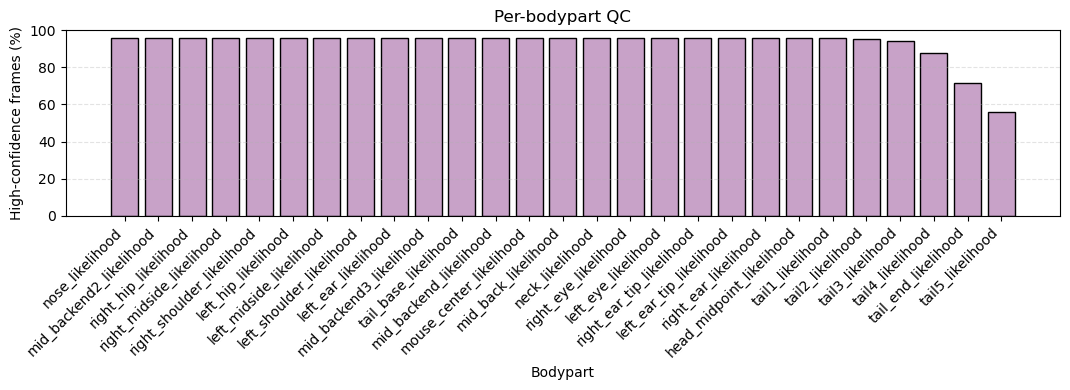

In [139]:
## 3.2 Quality control summary from likelihoods

def qc_summary_from_likelihood(df_one: pd.DataFrame, conf_thresh: float = 0.5) -> pd.DataFrame:
    """
    Compute per-bodypart detection quality metrics.
    
    Parameters
        df_one : Single-animal dataframe 
        conf_thresh : Confidence threshold to count a detection as 'high-confidence'
    """
    # >>>>>>>>>>>>>>>>>>>
    # TODO: select only likelihood columns
    # YOUR CODE HERE (1 line): 
    # L = df_one.filter( ... )
    L_raw = df_one.filter(like="_likelihood")
    # <<<<<<<<<<<<<<<<<<  

    # Fractions before cleaning (so we can measure true NaN vs -1 rates)
    #minus1_pct = L_raw.eq(-1).mean(axis=0) * 100

    # Replace invalid values (-1) with NaN so they’re ignored in summaries
    L = L_raw.where(L_raw >= 0)

    # Compute stats per bodypart (coverage, high_conf%, mean)
    per_bp = pd.DataFrame({
        # >>>>>>>>>>>>>>>>>>>
        # TODO: What fraction of frames have any valid detection (not all NaN)
        # YOUR CODE HERE (1 line), hint (notna(), mean()):
        # "coverage_%": L ...
        "coverage_%": L.notna().mean(axis=0) * 100,

        # TODO: What fraction of frames have likelihood ≥ conf_thresh (default 0.5)
        # YOUR CODE HERE (1 line): 
        # "high_conf_%": (L >= conf_thresh) ...
        "high_conf_%": (L >= conf_thresh).mean(axis=0) * 100,

        # TODO: Average likelihood, ignoring missing values
        # YOUR CODE HERE (1 line):
        # "mean_likelihood": ...
        "mean_likelihood": L.mean(axis=0),
        # <<<<<<<<<<<<<<<<<< 

        # Added: fractions of NaNs (-1, before cleaning)
        #"minus1_%": minus1_pct,
    }).sort_values("high_conf_%", ascending=False)
    
    return per_bp


def plot_likelihood_qc(per_bp: pd.DataFrame, title: str = "Per-bodypart QC"):
    """Quick QC bar plot of high-confidence detection rate (lilac)."""
    import matplotlib.pyplot as plt

    # Adjust figure size automatically to fit labels
    fig, ax = plt.subplots(figsize=(max(8, len(per_bp) * 0.4), 4))

    ax.bar(per_bp.index, per_bp["high_conf_%"],
           color="#C8A2C8", edgecolor="black")

    ax.set(title=title,
           xlabel="Bodypart",
           ylabel="High-confidence frames (%)",
           ylim=(0, 100))
    ax.grid(axis="y", linestyle="--", alpha=0.35)

    # Rotate labels so they don’t overlap
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


qc = qc_summary_from_likelihood(df_one)
display(qc)
plot_likelihood_qc(qc)


## 4. Time series inspection, looking for "bad" frames.

👉 Goal: detect failures and instability across time.

By logging the frames (time indices) where -1 or very low-likelihood values occur, you’re essentially mapping reliability gaps in your tracking. 

You can later use this information to guide cleaning and create a diagnosti visualization plot, and finally, decide if the video's results are good enough for downstream analysis.

💡 Idea:
- If the missing gap (bad_frames are consecutive) is short (e.g. < 10 frames), linear interpolation is fine.
- If the gap is long → keep NaNs to mark unreliable periods.

📝 **Instructions**

To do the above, let's first find the "bad" frames and inspect our results. 
1. 🧩 Complete the line marked with `# TODO` to complete the helper function `list_failure_segments`

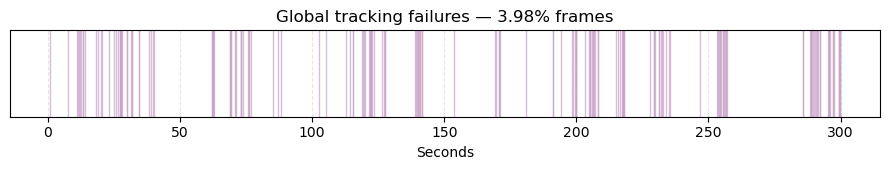

⚠️ Global tracking failure segments:
  1. Frames 17-17  (00:00.57 → 00:00.57)  [0.03s]
  2. Frames 228-228  (00:07.60 → 00:07.60)  [0.03s]
  3. Frames 331-331  (00:11.03 → 00:11.03)  [0.03s]
  4. Frames 342-342  (00:11.40 → 00:11.40)  [0.03s]
  5. Frames 348-348  (00:11.60 → 00:11.60)  [0.03s]
  6. Frames 359-359  (00:11.97 → 00:11.97)  [0.03s]
  7. Frames 379-379  (00:12.63 → 00:12.63)  [0.03s]
  8. Frames 398-398  (00:13.27 → 00:13.27)  [0.03s]
  9. Frames 401-401  (00:13.37 → 00:13.37)  [0.03s]
 10. Frames 420-422  (00:14.00 → 00:14.07)  [0.10s]
 11. Frames 544-546  (00:18.13 → 00:18.20)  [0.10s]
 12. Frames 562-566  (00:18.73 → 00:18.87)  [0.17s]
 13. Frames 601-601  (00:20.03 → 00:20.03)  [0.03s]
 14. Frames 608-608  (00:20.27 → 00:20.27)  [0.03s]
 15. Frames 693-693  (00:23.10 → 00:23.10)  [0.03s]
 16. Frames 754-754  (00:25.13 → 00:25.13)  [0.03s]
 17. Frames 768-777  (00:25.60 → 00:25.90)  [0.33s]
 18. Frames 791-799  (00:26.37 → 00:26.63)  [0.30s]
 19. Frames 813-815  (00:27.1

In [140]:

def list_failure_segments(df_one, fps: float) -> list[tuple[int, int, str, str]]:
    """
    Returns and prints consecutive -1 segments as (start_frame, end_frame, start_time, end_time)
    """
    # >>>>>>>>>>>>>>>>>>>
    # TODO: Frames where *all* likelihoods are -1
    # YOUR CODE HERE (1 line):
    # L = df_one.filter( ... )
    L = df_one.filter(like="_likelihood")
    # TODO: Compute 1D boolean array: True where all bodyparts are -1
    # YOUR CODE HERE (1 line):Hint: use .eq(-1), .all(axis=1), and .to_numpy() on L
    # fail - L...
    fail = L.eq(-1).all(axis=1).to_numpy()
    # <<<<<<<<<<<<<<<<<
    
    # Find consecutive True segments in fail (where all bodyparts are -1)
    segments = []
    for k, g in groupby(enumerate(fail), key=lambda x: x[1]):
        if k:  # only failing groups
            g = list(g)
            start = g[0][0]
            end = g[-1][0]
            # convert frames → time (minutes:seconds)
            t1, t2 = start / fps, end / fps
            m1, s1 = divmod(t1, 60)
            m2, s2 = divmod(t2, 60)
            start_str = f"{int(m1):02d}:{s1:05.2f}"
            end_str = f"{int(m2):02d}:{s2:05.2f}"
            segments.append((start, end, start_str, end_str))

    # Pretty print
    if not segments:
        print("✅ No global failure segments detected.")
    else:
        print("⚠️ Global tracking failure segments:")
        for i, (s, e, ts, te) in enumerate(segments, 1):
            dur = (e - s + 1) / fps
            print(f" {i:>2}. Frames {s}-{e}  ({ts} → {te})  [{dur:.2f}s]")

    return segments

def plot_global_failure_timeline(df_one, fps: float | None = None, title="Global tracking failures"):
    # Frames where *all* likelihoods are -1
    L = df_one.filter(like="_likelihood")
    fail = L.eq(-1).all(axis=1).to_numpy()
    x = np.arange(len(fail)) if fps is None else np.arange(len(fail)) / float(fps)

    fig, ax = plt.subplots(figsize=(9, 1.8))
    # Shade failure regions (lilac)
    ax.fill_between(x, 0, 1, where=fail, step="post", alpha=0.7, color="#C8A2C8")
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    ax.set_xlabel("Seconds" if fps else "Frames")
    pct = fail.mean() * 100
    ax.set_title(f"{title} — {pct:.2f}% frames")

    # Thin grid & tight layout
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_global_failure_timeline(df_one, fps=30)  # or fps=None if unknown
fails = list_failure_segments(df_one, fps=30)

## 5. Outliers

🛸 When a body part “teleports” between two consecutive frames is one of the most common tracking artefacts in pose estimation, these are called **position or spacial outliers**  👽 when a single detection in a frame is far from neighborhood, or **jump spikes** when the distance between consecutive frames is unrealistically large.  To detect those outliers we can compute motion speed and set a threshold. 

As each body part moves at different speeds, for example, a tail could move faster than the center of the body.  

Instead of using one fixed “jump” threshold for all body parts, we compute an automatic threshold for each one.

👉🏼 Goal: In the following cell we will be calculating a robust statistic called the **MAD** = Median Absolute Deviation. 

It’s a robust measure of spread (like standard deviation, but more resistant to outliers).

    MAD = median(|x_i - median(x)|)

Then we set a threshold:

    threshold = median(speed) + k x MAD(speed)

Typically k = 3 to 4.5.

It adapts automatically to each bodypart’s natural range of motion.

Why:
- Different body parts move differently (tail > body center).
- Absolute thresholds (e.g., 50 px) can be too strict or too loose.
- The MAD rule scales with data spread, so it works well across datasets.

### STEP 1 :Compute automatic thresholds (MAD rule)

📝 **Instructions**

🧩 Complete the line marked with `# TODO` in the `compute_mad_thresholds` function to compute the MAD.


In [141]:
# ===== Automatic jump threshold (MAD rule per bodypart) =====
# Must be run BEFORE the cleaning pipeline cell

def compute_mad_thresholds(df: pd.DataFrame, k: float = 3.5) -> dict[str, float]:
    """
    Compute per-bodypart jump threshold using median + k*MAD of valid speeds.
    Ignores frames where likelihood == -1 or previous frame was invalid.
    """
    parts = [c.replace("_likelihood", "") for c in df.filter(like="_likelihood").columns]
    thresholds = {}
    for p in parts:
        x = df[f"{p}_x"]; y = df[f"{p}_y"]; lik = df[f"{p}_likelihood"]

        # valid pairs = both current & previous frames detected
        detected_now  = lik.ne(-1)
        detected_prev = detected_now.shift(1, fill_value=False)
        valid_pair = detected_now & detected_prev

        dx = x.diff(); dy = y.diff()
        speed = np.hypot(dx, dy).where(valid_pair)

        med = float(speed.median(skipna=True) or 0)
        mad = float((speed - med).abs().median(skipna=True) or 0)
        
        # >>>>>>>>>>>>>>>>>>>
        # TODO: Compute threshold
        # YOUR CODE HERE (1 line):
        # thr = ...
        thr = med + k * mad
        # <<<<<<<<<<<<<<<<<

        thresholds[p] = max(thr, 10.0)  # safety floor (10 px/frame)
    return thresholds

# ---- compute and preview thresholds ----
MAD_K = 3.5
auto_thresholds = compute_mad_thresholds(df_one, k=MAD_K)

print(f"Computed automatic thresholds (MAD rule, k={MAD_K}):")
for part, thr in auto_thresholds.items():
    print(f" - {part:>12s}: {thr:6.2f} px/frame")

Computed automatic thresholds (MAD rule, k=3.5):
 -         nose:  10.62 px/frame
 -     left_ear:  10.00 px/frame
 -    right_ear:  10.00 px/frame
 - left_ear_tip:  10.00 px/frame
 - right_ear_tip:  10.00 px/frame
 -     left_eye:  10.00 px/frame
 -    right_eye:  10.00 px/frame
 -         neck:  10.00 px/frame
 -     mid_back:  10.00 px/frame
 - mouse_center:  10.00 px/frame
 -  mid_backend:  10.00 px/frame
 - mid_backend2:  10.00 px/frame
 - mid_backend3:  10.00 px/frame
 -    tail_base:  10.00 px/frame
 -        tail1:  10.00 px/frame
 -        tail2:  10.00 px/frame
 -        tail3:  10.00 px/frame
 -        tail4:  10.58 px/frame
 -        tail5:  13.28 px/frame
 - left_shoulder:  10.00 px/frame
 - left_midside:  10.00 px/frame
 -     left_hip:  10.00 px/frame
 - right_shoulder:  10.00 px/frame
 - right_midside:  10.00 px/frame
 -    right_hip:  10.00 px/frame
 -     tail_end:  12.34 px/frame
 - head_midpoint:  10.00 px/frame



### STEP 2 :  Identify “bad” frames (mask creation)
For each frame and body part, we mark whether the data should be ignored (masked):
1.	Missing detections: frames where likelihood = -1. 
2.	Jump outliers: frames where the motion speed is above the MAD threshold, and both current and previous frames were valid detections.

We also detect global failures, when all body parts are -1 in a frame (the tracker completely lost the animal), as seen in the previous step. 

These masks are just True/False arrays — they do not change the data yet.

### STEP 3: Apply masks (replace invalid values)

We apply the masks to the data:
- Wherever a mask is True, we replace that (x, y) position with NaN.
- This marks the frame as missing, so later we can fill or ignore it.

This makes our data cleaner and safer to process, we never trust values from bad detections

### Step 4: Interpolate short gaps only

After masking, some parts of the trajectory have short gaps.
If the gap is shorter than a few frames (for example ≤ 10 frames ≈ 0.3 s at 30 fps), we can interpolate to fill it smoothly.

Interpolation estimates the missing points by connecting the last and next valid positions — like “drawing a straight line” through short missing segments.
- Linear interpolation works well for most cases.
- For longer gaps, we leave them as NaN because we can’t safely guess the motion.

### Step 5:  Light temporal smoothing

Even with valid detections, small pixel-level “jitter” can appear.
We apply a rolling median filter (e.g. window = 5 frames) to smooth sudden tiny oscillations.
- It reduces noise without distorting real motion.
- Keep the window small so we don’t blur fast behaviors.

### Step 6: Save the cleaned dataset

Finally, we save the cleaned DataFrame to an HDF5 file (cleaned_pose.h5).
This file keeps the same structure as the original one, but with:
- invalid frames replaced by NaN,
- short gaps interpolated,
- (optional) smoothing applied.

You can now use this cleaned dataset for further analysis (behavior classification, trajectory plots, etc.) with much higher reliability.

In [142]:
# ===== Pose cleaning (only -1 & jumps, with MAD thresholds) =====
# - Masks frames with likelihood == -1 and jump spikes (using per-part MAD thresholds)
# - Pure / idempotent: no in-place mutations of inputs
# -----------------------------
# Parameters (tune per dataset)
# -----------------------------
FPS = 30.0
MAX_SPEED_PX_PER_FRAME = 50.0    # used ONLY if a part has no MAD threshold
MAX_SHORT_GAP = 10               # frames; interpolate gaps ≤ this
INTERP_METHOD = "linear"
APPLY_SMOOTHING = True
SMOOTH_WINDOW = 5                # odd, small (3–7)
H5_OUT = "cleaned_pose.h5"

# -------------------------------------------
# Helpers
# -------------------------------------------
def get_parts(df: pd.DataFrame) -> list[str]:
    """Extract body-part names from *_likelihood columns."""
    return [c.replace("_likelihood", "") for c in df.filter(like="_likelihood").columns]

def build_masks_only_neg1_and_jumps(
    df: pd.DataFrame,
    max_speed_px_per_frame: float = MAX_SPEED_PX_PER_FRAME,
    thresholds: dict | None = None,   # NEW: per-part MAD thresholds
):
    """
    Returns:
      global_mask: True where ALL bodyparts have likelihood == -1 in that frame
      part_masks: dict[part] -> True where (lik == -1) OR (jump spike when both frames detected)
    Uses per-part thresholds if provided; otherwise falls back to fixed max_speed_px_per_frame.
    """
    parts = get_parts(df)

    # Global "-1 for all parts" mask (per frame)
    L = df.filter(like="_likelihood")
    global_mask = L.eq(-1).all(axis=1)

    # Per-part masks: (-1) OR valid jump spike
    part_masks = {}
    for p in parts:
        lik = df[f"{p}_likelihood"]
        x   = df[f"{p}_x"]
        y   = df[f"{p}_y"]

        # 1) explicit non-detections
        neg1 = lik.eq(-1)

        # 2) per-frame speed (using previous frame diffs)
        dx = x.diff()
        dy = y.diff()
        speed = np.hypot(dx, dy)

        # 3) a "valid pair" means both current and previous frames were detected
        detected_now  = lik.ne(-1)
        detected_prev = detected_now.shift(1, fill_value=False)  # False at first frame
        valid_pair = detected_now & detected_prev

        # 4) pick threshold: MAD per-part if available, else fixed
        thr = thresholds.get(p, max_speed_px_per_frame) if thresholds is not None else max_speed_px_per_frame

        # 5) jump outliers only where the pair is valid
        jump = (speed > thr) & valid_pair

        # final per-part mask
        part_masks[p] = neg1 | jump

    return global_mask, part_masks

def apply_masks(df: pd.DataFrame, global_mask: pd.Series, part_masks: dict) -> pd.DataFrame:
    """Return a NEW DataFrame with masked (x,y) set to NaN."""
    out = df.copy(deep=True)
    parts = get_parts(out)
    # Global: apply to all parts (x,y)
    all_xy = [f"{p}_x" for p in parts] + [f"{p}_y" for p in parts]
    out.loc[global_mask, all_xy] = np.nan
    # Per-part
    for p, m in part_masks.items():
        out.loc[m, [f"{p}_x", f"{p}_y"]] = np.nan
    return out


def interpolate_short_gaps(df: pd.DataFrame, max_gap: int = MAX_SHORT_GAP, method: str = INTERP_METHOD) -> pd.DataFrame:
    """Return NEW DataFrame with short NaN gaps interpolated."""
    out = df.copy(deep=True)
    for p in get_parts(out):
        for axis in ("_x", "_y"):
            col = f"{p}{axis}"
            # TODO (students): try 'linear' vs 'spline' (order=2) and note differences
            out[col] = out[col].interpolate(method=method, limit=max_gap, limit_direction="both")
    return out

def smooth_positions(df: pd.DataFrame, window: int = SMOOTH_WINDOW) -> pd.DataFrame:
    """Return NEW DataFrame with rolling-median smoothing (centered)."""
    out = df.copy(deep=True)
    for p in get_parts(out):
        for axis in ("_x", "_y"):
            col = f"{p}{axis}"
            out[col] = out[col].rolling(window=window, center=True, min_periods=1).median()
    return out

def percent_nans(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for p in get_parts(df):
        rows.append({
            "part": p,
            "NaN_x_%": float(df[f"{p}_x"].isna().mean() * 100),
            "NaN_y_%": float(df[f"{p}_y"].isna().mean() * 100),
        })
    return pd.DataFrame(rows).set_index("part")

def speed_summary(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for p in get_parts(df):
        x = df[f"{p}_x"]; y = df[f"{p}_y"]
        speed = np.hypot(x.diff(), y.diff())
        rows.append({
            "part": p,
            "speed_median": float(speed.median(skipna=True) or 0),
            "speed_p95": float(speed.quantile(0.95)),
            "speed_max": float(speed.max(skipna=True) or 0),
        })
    return pd.DataFrame(rows).set_index("part")

def quick_mask_report(global_mask: pd.Series, part_masks: dict, thresholds: dict | None = None):
    if thresholds is not None:
        print("Per-part jump thresholds (MAD rule):")
        for p in get_parts(global_mask.to_frame().join(global_mask.to_frame(), how="left", rsuffix="_r")):
            if p in thresholds:
                print(f" - {p:>12s}: {thresholds[p]:6.2f} px/frame")
    print(f"\nGlobal all-parts == -1: {global_mask.sum()} frames ({100*global_mask.mean():.2f}%)")
    for p, m in part_masks.items():
        print(f"- {p:>12s}: masked {m.sum():5d} frames ({100*m.mean():5.2f}%)")

# -------------------------------------------
# Pipeline (df_one = your raw predictions)
# -------------------------------------------
# IMPORTANT: start from deep copies -> idempotent runs
df_raw   = df_one.copy(deep=True)
df_stage = df_raw.copy(deep=True)

# 1) Build masks (only -1 and MAD-based jumps)
gmask, pmasks = build_masks_only_neg1_and_jumps(
    df_stage,
    max_speed_px_per_frame=MAX_SPEED_PX_PER_FRAME,   # fallback
    thresholds=auto_thresholds                       # <-- from previous cell
)
quick_mask_report(gmask, pmasks, thresholds=auto_thresholds)

# 2) Apply masks → set bad (x,y) to NaN (NEW df)
df_stage = apply_masks(df_stage, gmask, pmasks)

# 3) Interpolate short gaps ONLY (NEW df)
df_stage = interpolate_short_gaps(df_stage, max_gap=MAX_SHORT_GAP, method=INTERP_METHOD)

# 4) Optional light smoothing (NEW df)
if APPLY_SMOOTHING:
    df_stage = smooth_positions(df_stage, window=SMOOTH_WINDOW)

df_clean = df_stage  # final cleaned dataframe

# 5) Compare before/after
print("\n=== % NaNs BEFORE ===")
print(percent_nans(df_raw.where(df_raw >= 0)))
print("\n=== % NaNs AFTER  ===")
print(percent_nans(df_clean))

print("\n=== Speed summary BEFORE ===")
print(speed_summary(df_raw))
print("\n=== Speed summary AFTER  ===")
print(speed_summary(df_clean))

# 6) Save cleaned H5 (overwrites deterministically)
df_clean.to_hdf(H5_OUT, key="df_with_missing", mode="w")
print(f"\n✅ Saved cleaned file to: {H5_OUT}")

Per-part jump thresholds (MAD rule):

Global all-parts == -1: 358 frames (3.98%)
-         nose: masked   565 frames ( 6.28%)
-     left_ear: masked   637 frames ( 7.08%)
-    right_ear: masked   667 frames ( 7.41%)
- left_ear_tip: masked   680 frames ( 7.56%)
- right_ear_tip: masked   805 frames ( 8.94%)
-     left_eye: masked   593 frames ( 6.59%)
-    right_eye: masked   632 frames ( 7.02%)
-         neck: masked   621 frames ( 6.90%)
-     mid_back: masked   604 frames ( 6.71%)
- mouse_center: masked   590 frames ( 6.56%)
-  mid_backend: masked   693 frames ( 7.70%)
- mid_backend2: masked   650 frames ( 7.22%)
- mid_backend3: masked   680 frames ( 7.56%)
-    tail_base: masked   629 frames ( 6.99%)
-        tail1: masked   896 frames ( 9.96%)
-        tail2: masked  1197 frames (13.30%)
-        tail3: masked  1161 frames (12.90%)
-        tail4: masked  1274 frames (14.16%)
-        tail5: masked  1471 frames (16.34%)
- left_shoulder: masked   713 frames ( 7.92%)
- left_midside: m

### Compare before / after cleaning

After running the pre-processing pipeline pipeline, we print two key summaries:

1. ** % of NaN frames per body part**  
   This tells us **how much of the trajectory was marked as invalid or interpolated**.  
   - **Low NaN % (0–5%)** → Excellent tracking; only a few missing or bad frames.  
   - **Moderate NaN % (5–15%)** → Normal for realistic data, often due to brief occlusions or lighting changes.  
   - **High NaN % (>20%)** → Something may be wrong — the tracker struggled a lot, or parameters might be too strict.  
   
   👉 *Think of NaN percentage as the “data confidence score” for each body part.*

   If one part (e.g., tail tip) has a much higher NaN %, it might simply be harder to detect consistently — or your camera angle hides it often.


2. **⚡ Speed summary (median / p95 / max)**  
   This describes the **distribution of movement speeds** for each body part.  
   - **Median speed** → Typical motion magnitude.  
   - **95th percentile (p95)** → Usual upper limit for realistic movements.  
   - **Max speed** → The largest observed jump — a good check for outliers.

   After cleaning:
   - The **max** and **p95 speeds** should usually **drop** compared to before cleaning.  
   - The **median speed** should stay **about the same** (since normal movement shouldn’t be affected).  
   - If all speeds drop drastically, you may have over-filtered (too aggressive thresholds or too much smoothing).

---

### 🧠 How to reason about your results

Ask yourself:
- Did the cleaning remove obvious outliers but keep natural motion?  
- Are certain body parts more problematic (many NaNs or very high speeds)? Why might that be?  
- Would adjusting the MAD `k` value (or interpolation length) change the balance between “clean” and “over-filtered”?


> ✅ **Goal:** After cleaning, the data should look smoother and more realistic —  
> no “teleportations,” no jitter, but still preserving the true dynamics of the animal’s behavior.


**Summary of the Pose Cleaning Pipeline**

| **Step** | **What happens** | **Why** |
|-----------|------------------|--------------------|
| **1. Auto thresholds (MAD rule)** | Compute each body part’s typical movement speed using the Median + *k* × MAD rule. | Each body part moves differently — this gives an adaptive limit for what counts as an unrealistic “jump.” |
| **2. Mask bad frames** | Mark frames where likelihood = -1 or where the movement speed exceeds the threshold. | Flags missing or impossible detections to prevent them from affecting analysis. |
| **3. Apply masks** | Replace bad frames with `NaN` (missing values). | Prepares the data for safe interpolation — no false coordinates remain. |
| **4. Interpolate short gaps** | Fill small consecutive NaN gaps (e.g., ≤ 10 frames) using linear interpolation. | Maintains smooth continuity for short interruptions without inventing long motions. |
| **5. Smooth positions** | Apply a short rolling median filter (e.g., 5 frames). | Removes pixel-level jitter while keeping real motion intact. |

---

### 💡 Reflection: One Possible Pre-Processing Pipeline

The pipeline above is a **proposed and general approach** for cleaning pose-estimation data.  
It works well for many experiments — but it is **not the only possible method**.

Different laboratories, species, and recording setups often require **adjustments**:
- Frame rates, lighting, or background noise can affect what counts as an outlier.  
- Some projects prioritize **precision** (fewer interpolations), while others prioritize **continuity** (smoother trajectories).  
- Advanced methods might include **Kalman filters**, **Gaussian process smoothing**, or even **model retraining** on difficult frames.

There is no single “best” cleaning procedure — the right one depends on:
- The **scientific question** (e.g., fine kinematics vs. coarse behavior).  
- The **quality and type** of the recordings.  
- The **tolerance for uncertainty** in motion tracking.


> 🗣️ *Think about how you would adapt this cleaning pipeline to your own data — what stays the same, and what would you change?*


## Supplementary . Spatial distributions

### 🎯 Likelihood Heatmap: Quick Explanation

This function visualizes **where the tracker performs well or poorly** by plotting the **average likelihood** across space.

`_discover_triplets(df)`

Finds matching columns `*_x`, `*_y`, and `*_likelihood` for each bodypart (e.g. `nose_x`, `nose_y`, `nose_likelihood`).  
➡️ Makes it easy to loop over all tracked points.


🗺️ `likelihood_heatmap(df_one, ...)`

1. Collects all `(x, y, likelihood)` values (ignoring `-1` = missing).  
2. Divides the image into a 2D grid (bins).  
3. Computes the **mean likelihood per cell**.  
4. Masks cells with too few samples (to avoid noise).  
5. Displays a **heatmap** where:
   - **Bright areas** → reliable tracking  
   - **Dark areas** → frequent tracking loss  

#### 💡 Why it’s useful
Helps detect **where in the arena the model struggles** (e.g., edges, reflections, shadows).  
Use it to decide if you need more labels, better lighting, or camera calibration.


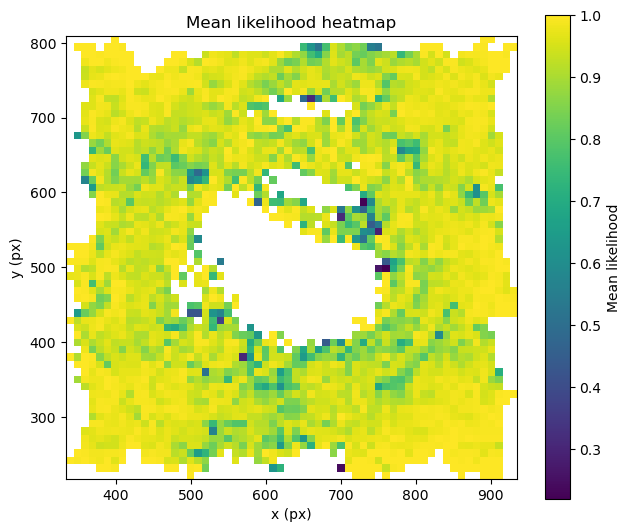

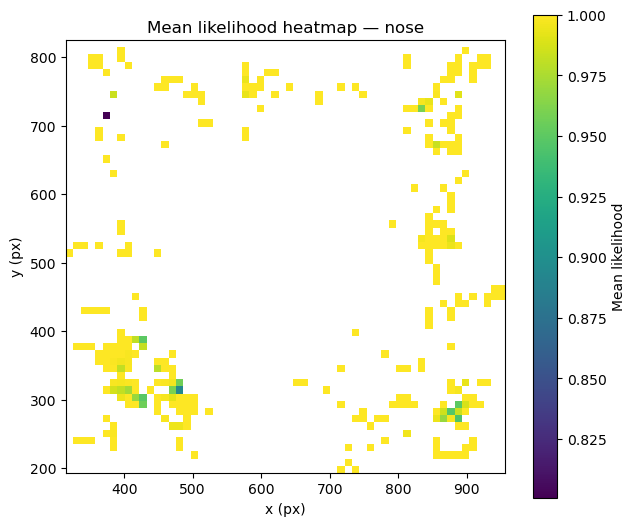

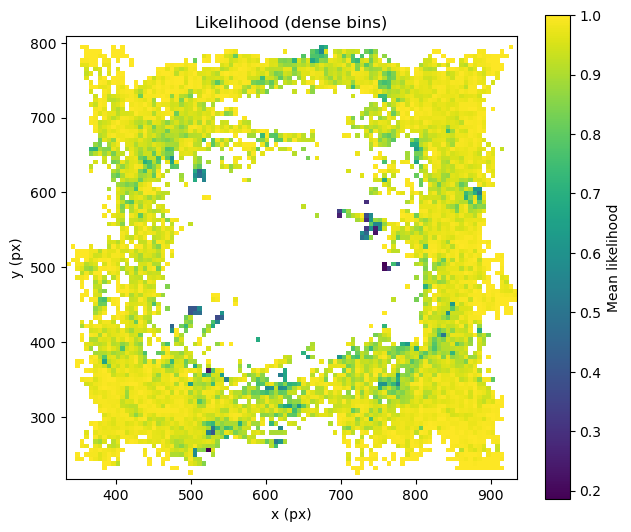

{'fig': <Figure size 650x550 with 2 Axes>,
 'ax': <Axes: title={'center': 'Likelihood (dense bins)'}, xlabel='x (px)', ylabel='y (px)'>,
 'H_mean': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1.,  1., nan],
        ...,
        [ 1., nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ...,  1.,  1., nan],
        [nan, nan, nan, ...,  1.,  1., nan]]),
 'H_count': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  5.,  8.,  0.],
        ...,
        [ 1.,  0.,  0., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 15.,  2.,  0.],
        [ 0.,  0.,  0., ...,  3.,  3.,  0.]]),
 'xedges': array([333.1140625 , 339.13896875, 345.163875  , 351.18878125,
        357.2136875 , 363.23859375, 369.2635    , 375.28840625,
        381.3133125 , 387.33821875, 393.363125  , 399.38803125,
        405.4129375 , 411.43784375, 417.46275   , 423.48765625,
      

In [143]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _discover_triplets(df: pd.DataFrame) -> dict[str, tuple[str,str,str]]:
    """
    Retourne un dict {prefix: (x_col, y_col, like_col)} en détectant les triplets *_x, *_y, *_likelihood.
    Compatible single/multi-animal (ex: 'animal0_nose_x').
    """
    x_cols  = {m.group(1): col for col in df.columns if (m:=re.match(r"(.+)_x$", col))}
    y_cols  = {m.group(1): col for col in df.columns if (m:=re.match(r"(.+)_y$", col))}
    l_cols  = {m.group(1): col for col in df.columns if (m:=re.match(r"(.+)_likelihood$", col))}
    prefixes = set(x_cols) & set(y_cols) & set(l_cols)
    return {p: (x_cols[p], y_cols[p], l_cols[p]) for p in sorted(prefixes)}

def likelihood_heatmap(
    df_one: pd.DataFrame,
    bodyparts: list[str] | None = None,
    bins: int | tuple[int,int] = 60,
    extent: tuple[float,float,float,float] | None = None,
    min_count_per_bin: int = 5,
    title: str = "Mean likelihood heatmap",
):
    """
    Affiche une heatmap de la *moyenne du likelihood* par position (x,y).

    Params
    ------
    bodyparts : liste optionnelle des 'prefixes' à inclure (ex: ['nose', 'animal0_nose']).
                Par défaut, utilise tous les triplets trouvés.
    bins      : nb de bacs (int) ou (nx, ny) pour histogramme 2D.
    extent    : (xmin, xmax, ymin, ymax) pour fixer les limites. Par défaut, auto depuis les données.
    min_count_per_bin : masque les bacs trop peu peuplés (< ce seuil).
    """
    triplets = _discover_triplets(df_one)
    if not triplets:
        raise ValueError("Aucun triplet *_x, *_y, *_likelihood* détecté.")

    if bodyparts is not None:
        missing = [bp for bp in bodyparts if bp not in triplets]
        if missing:
            raise ValueError(f"Bodyparts inconnus: {missing}\nDisponibles: {list(triplets.keys())}")
        use = {bp: triplets[bp] for bp in bodyparts}
    else:
        use = triplets

    # Concaténer toutes les positions & likelihood sélectionnées
    xs, ys, ls = [], [], []
    for (x_col, y_col, l_col) in use.values():
        x = df_one[x_col].to_numpy(dtype=float, copy=False)
        y = df_one[y_col].to_numpy(dtype=float, copy=False)
        L = df_one[l_col].to_numpy(dtype=float, copy=False)

        # Remplacer sentinelles -1 par NaN
        x[x < 0] = np.nan
        y[y < 0] = np.nan
        L[L < 0] = np.nan  # SuperModel peut mettre -1 en likelihood

        # Garder uniquement les points valides (x,y,l non-NaN)
        valid = (~np.isnan(x)) & (~np.isnan(y)) & (~np.isnan(L))
        xs.append(x[valid]); ys.append(y[valid]); ls.append(L[valid])

    if not xs:
        raise ValueError("Aucune donnée valide après nettoyage.")
    X = np.concatenate(xs)
    Y = np.concatenate(ys)
    W = np.concatenate(ls)

    # Définir l'étendue automatiquement si non fournie
    if extent is None:
        xmin, xmax = np.nanpercentile(X, [1, 99])
        ymin, ymax = np.nanpercentile(Y, [1, 99])
        # petite marge
        dx = (xmax - xmin) * 0.05
        dy = (ymax - ymin) * 0.05
        extent = (xmin - dx, xmax + dx, ymin - dy, ymax + dy)

    # Histogrammes 2D: somme des likelihoods et compte d'échantillons
    H_sum, xedges, yedges = np.histogram2d(X, Y, bins=bins, range=[[extent[0], extent[1]], [extent[2], extent[3]]], weights=W)
    H_cnt, _,     _      = np.histogram2d(X, Y, bins=[xedges, yedges])

    # Moyenne du likelihood par bin
    with np.errstate(invalid="ignore", divide="ignore"):
        H_mean = H_sum / H_cnt

    # Masquer bacs trop vides
    H_mean_masked = np.where(H_cnt >= max(1, min_count_per_bin), H_mean, np.nan)

    # Plot
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(
        H_mean_masked.T,
        origin="lower",
        extent=extent,
        aspect="equal",
        interpolation="nearest",
    )
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Mean likelihood")

    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.set_title(title + ("" if bodyparts is None else f" — {', '.join(use.keys())}"))
    plt.tight_layout()
    plt.show()

    return {
        "fig": fig, "ax": ax,
        "H_mean": H_mean, "H_count": H_cnt,
        "xedges": xedges, "yedges": yedges, "extent": extent
    }

# --- Exemples d'utilisation ---
# 1) Heatmap globale (tous les bodyparts disponibles)
likelihood_heatmap(df_one)

# 2) Focaliser sur un bodypart (selon vos colonnes, ex: 'animal0_nose' ou juste 'nose')
likelihood_heatmap(df_one, bodyparts=['nose'])

# 3) Grille plus fine et seuil de comptage plus strict
likelihood_heatmap(df_one, bins=100, min_count_per_bin=10, title="Likelihood (dense bins)")

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/LizbethMG-Teaching/pose2behav-book/blob/main/notebooks/EDA.ipynb)]